# Introduction

### Import the libraries

In [568]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#useful tools
from sklearn.model_selection import cross_validate
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)


### Notebook display settings

In [569]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings("ignore")

### Default figure settings

In [570]:
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.titleweight']='bold'
mpl.rcParams['axes.labelweight']='normal'
mpl.rcParams['figure.figsize']=(8,6)
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "Arial"

### Get the number of cpu

In [571]:
import multiprocessing as mp
n_cpu=mp.cpu_count()

# Data Transformation & Exploration

### Read the data

In [572]:
training_data=pd.read_csv('Data/epl-training.csv')
# Dropping the trailing columns
training_data.dropna(axis=1, how='all',inplace=True)
training_data.drop([column for column in training_data.columns if 'Unnamed' in column], axis = 1, inplace=True) 
#print('shape: ', training_data.shape)

#check about the datatypes, some attributes are needed to be encoded for the subsequent processes.
training_data.dtypes

training_data.shape

(4180, 22)

In [573]:
training_data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/2008,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0
1,16/08/2008,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0
2,16/08/2008,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0
3,16/08/2008,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0
4,16/08/2008,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0


### Exploratory Data Analysis

In [574]:
def get_pivot_column_vs_column_count(df,col1,col2):
    return df.groupby([col1,col2]).size().reset_index().\
              rename(columns={0:'counts'}).\
              pivot(values='counts',index=col1,columns=col2)

In [575]:
def get_column_countplot(df,col,y='FTR',ax=None ):
    if ax is None:
        ax = plt.gca()
    df.groupby([col, y]).size().reset_index().\
       pivot(columns=y, index=col, values=0).\
       plot(kind='bar', stacked=True,ax=ax)
    ax.set_xlabel(col)
    ax.set_ylabel('Counts')
    ax.set_title('Count Plot: %s'%(col))

#### Number of matches

In [576]:
get_pivot_column_vs_column_count(training_data,'HomeTeam','AwayTeam')

AwayTeam,Arsenal,Aston Villa,Birmingham,Blackburn,Blackpool,Bolton,Bournemouth,Brighton,Burnley,Cardiff,Chelsea,Crystal Palace,Everton,Fulham,Huddersfield,Hull,Leicester,Liverpool,Man City,Man United,Middlesbrough,Newcastle,Norwich,Portsmouth,QPR,Reading,Southampton,Stoke,Sunderland,Swansea,Tottenham,Watford,West Brom,West Ham,Wigan,Wolves
HomeTeam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Arsenal,NaN,8.0,2.0,4.0,1.0,4.0,4.0,2.0,5.0,2.0,11.0,6.0,11.0,7.0,2.0,5.0,5.0,11.0,11.0,11.0,2.0,9.0,4.0,2.0,3.0,1.0,7.0,10.0,9.0,7.0,11.0,4.0,9.0,10.0,5.0,4.0
Aston Villa,8.0,NaN,2.0,4.0,1.0,4.0,1.0,NaN,2.0,1.0,8.0,3.0,8.0,6.0,NaN,4.0,2.0,8.0,8.0,8.0,1.0,7.0,4.0,2.0,3.0,1.0,4.0,8.0,8.0,5.0,8.0,1.0,7.0,7.0,5.0,3.0
Birmingham,2.0,2.0,NaN,2.0,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,1.0,2.0,2.0,2.0
Blackburn,4.0,4.0,2.0,NaN,1.0,4.0,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Blackpool,1.0,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0
Bolton,4.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,1.0,NaN,4.0,NaN,4.0,4.0,NaN,2.0,NaN,4.0,4.0,4.0,1.0,3.0,1.0,2.0,1.0,NaN,NaN,4.0,4.0,1.0,4.0,NaN,3.0,3.0,4.0,3.0
Bournemouth,4.0,1.0,NaN,NaN,NaN,NaN,NaN,2.0,3.0,1.0,4.0,4.0,4.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,4.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,NaN,1.0
Brighton,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,1.0,2.0,2.0,2.0,1.0,2.0,NaN,2.0,2.0,2.0,2.0,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,1.0,2.0,2.0,1.0,2.0,NaN,1.0
Burnley,5.0,2.0,1.0,1.0,NaN,1.0,3.0,2.0,NaN,1.0,5.0,4.0,5.0,2.0,2.0,3.0,4.0,5.0,5.0,5.0,1.0,3.0,NaN,1.0,1.0,NaN,4.0,4.0,3.0,3.0,5.0,3.0,3.0,5.0,1.0,2.0


### HTR vs. FTR

In [577]:
get_pivot_column_vs_column_count(training_data,'HTR','FTR')

FTR,A,D,H
HTR,,,
A,703,199,99
D,439,647,646
H,70,191,1186


In [578]:
cat_col_list=[x for x in training_data.columns\
              if x not in ['Date','HomeTeam','AwayTeam','Referee','FTR','HTR']]


In [579]:
cat_col_list = np.reshape(cat_col_list, (8, 2))

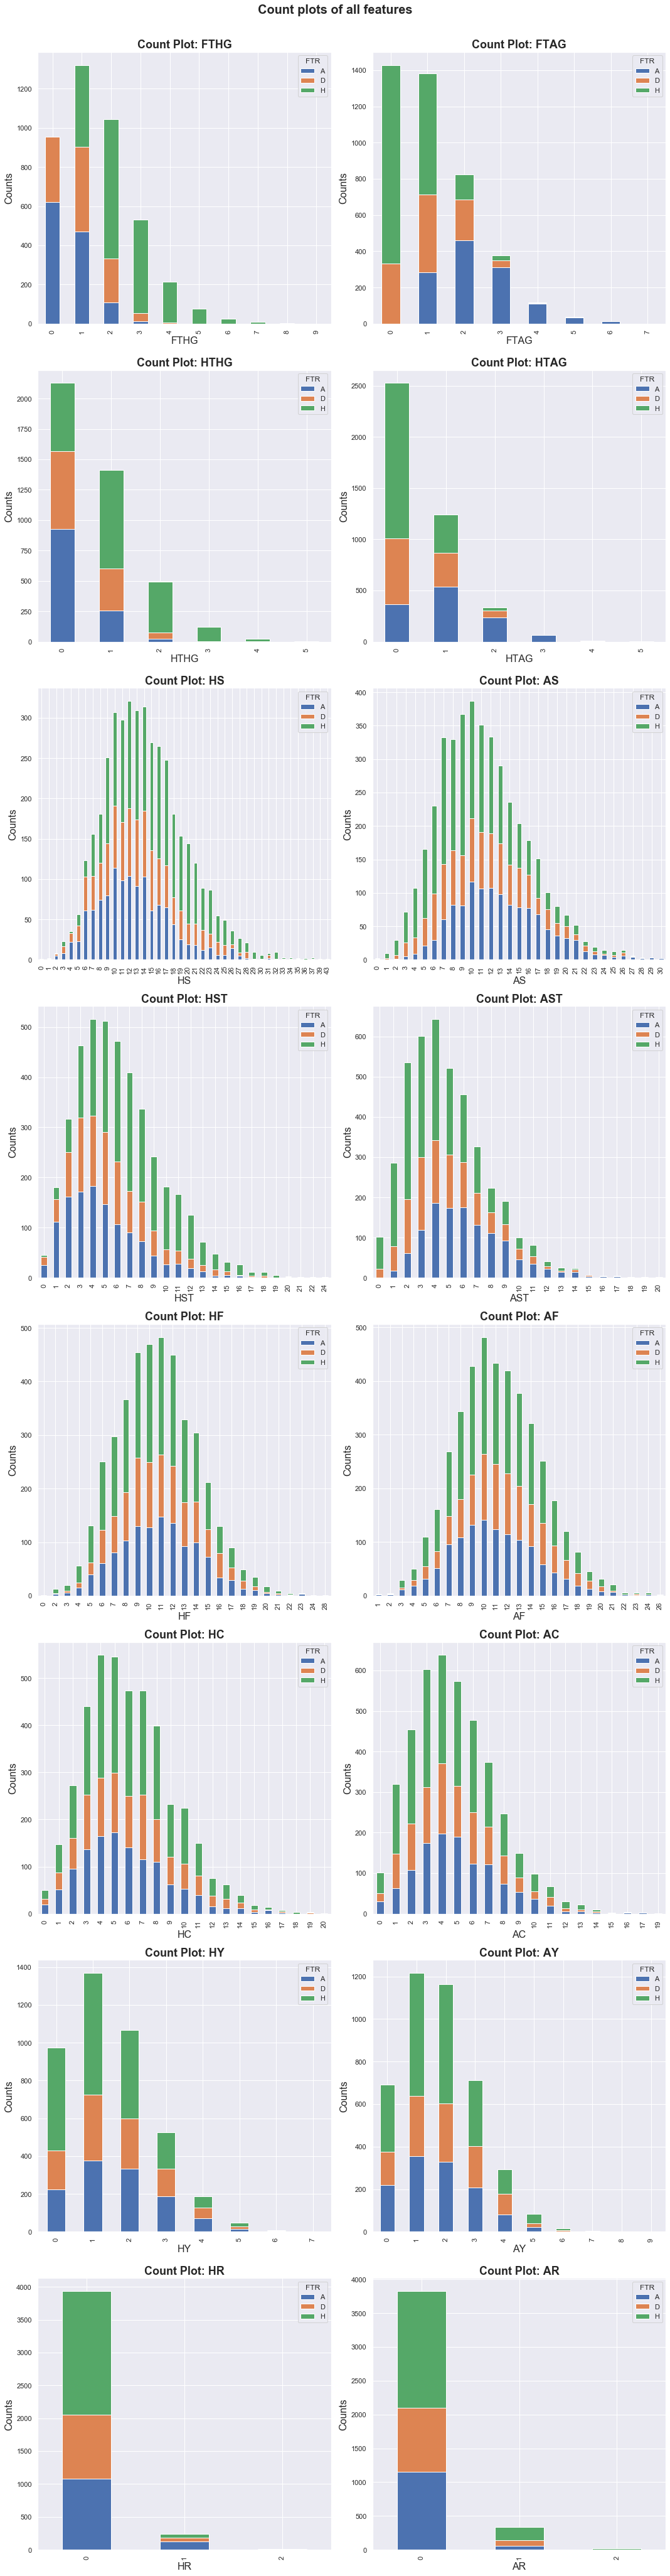

In [580]:
fig, axes = plt.subplots(8,2,figsize=(15,60))
for i in range(8):
    for j in range(2):
        get_column_countplot(training_data,cat_col_list[i][j], ax=axes[i,j])
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle("Count plots of all features",fontweight='bold',fontsize=20)
plt.show()

### Checking the dataset is balanced

In [581]:
count_val=training_data['FTR'].value_counts()

In [582]:
count_val

H    1931
A    1212
D    1037
Name: FTR, dtype: int64

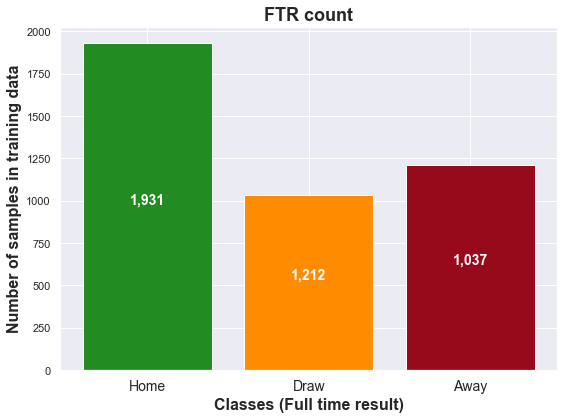

In [583]:
count_val=training_data['FTR'].value_counts()

#Visualising the count
X_ticks=['Home','Draw','Away']
bar_width=0.7
fig,ax=plt.subplots()
plt.bar(1,count_val[0],color='forestgreen')
plt.bar(2,count_val[2],color='darkorange')
plt.bar(3,count_val[1],color='#970a1b')
plt.text(1, count_val[0]/2, "{:,}".format(count_val[0]),color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(2, count_val[2]/2, "{:,}".format(count_val[1]), color='w'
         ,ha='center', va= 'bottom',fontweight='bold',fontsize=14)
plt.text(3, count_val[1]/2, "{:,}".format(count_val[2]), color='w',
         ha='center', va= 'bottom',fontweight='bold',fontsize=14)
ax.set_title('FTR count',fontsize=18,fontweight='bold')
ax.set_xlabel('Classes (Full time result)',fontsize=16,fontweight='bold')
ax.set_ylabel('Number of samples in training data',fontsize=16,
              fontweight='bold')
ax.set_xticks([1,2,3])
ax.set_xticklabels(X_ticks,fontsize=14)
fig.tight_layout()
plt.show()

### Calculate the correlation between the features

In [584]:
correlation = training_data.corr()
corr_array  = np.array(correlation)

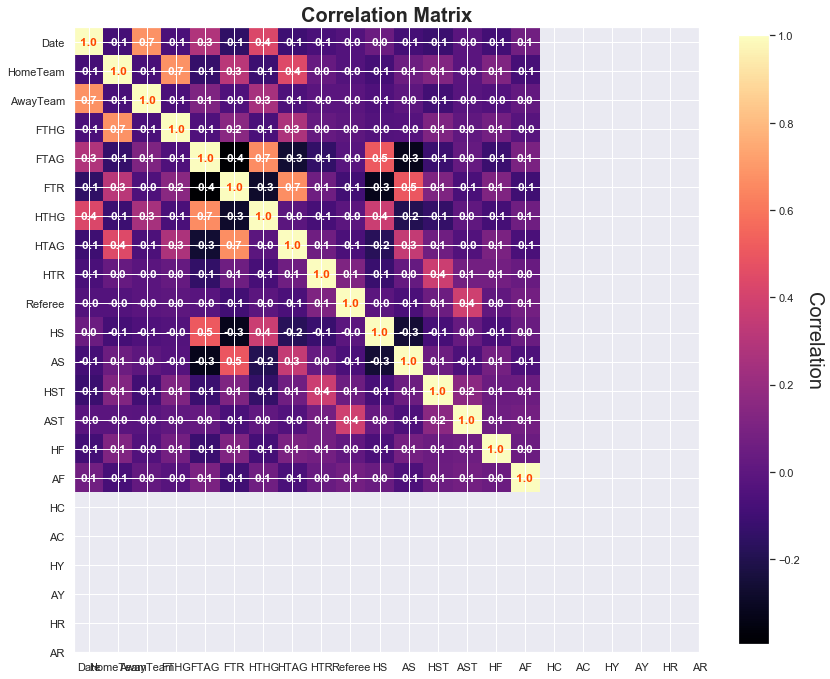

In [585]:
fig, ax = plt.subplots(figsize=(14,14))
im = ax.imshow(corr_array,cmap='magma')
cbar = ax.figure.colorbar(im, ax=ax,shrink=0.8)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom",fontsize=20)
data = im.get_array()
textcolors=['#FFFFFF','#FF4500']
for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, '%1.1f'%data[i, j], 
                                color=textcolors[data[i, j]>0.85],
                                ha='center',va='center',fontweight='bold')
ax.set_title('Correlation Matrix',fontsize=20,fontweight='bold')
ax.set_xticks(np.arange(len(training_data.columns.tolist())))
ax.set_yticks(np.arange(len(training_data.columns)))
ax.set_xticklabels(training_data.columns)
ax.set_yticklabels(training_data.columns)
plt.show()

### My playing with data

In [586]:
#some functions
#can help for pridicting team's general strength when a strong team scores a lot agianst a week team
def trim_df_data(df, q1 = 0.25, q2 = 0.75):
    Q1 = df.quantile(q1); Q3 = df.quantile(q2)
    df_trimmed = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_trimmed

number of duplicate rows:  (0, 22)
(4032, 22) (4180, 22)


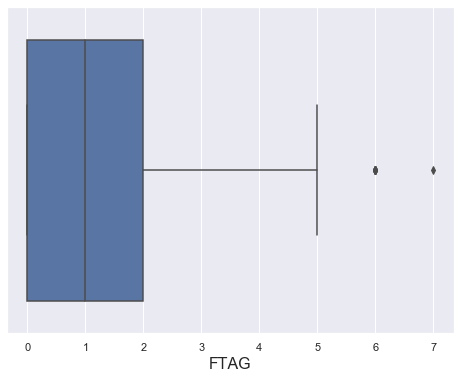

In [587]:
#chech the dataset has duplicate data
df = training_data
duplicate_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

#comfirming if there is null value from the dataset.
#print(df.isnull().sum()) #ans is no, so no need to consider policy dealing with them
sns.boxplot(x=df['FTAG'])

df_trimmed = trim_df_data(df, q1=0.05, q2 = 0.95)
print(df_trimmed.shape, df.shape)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


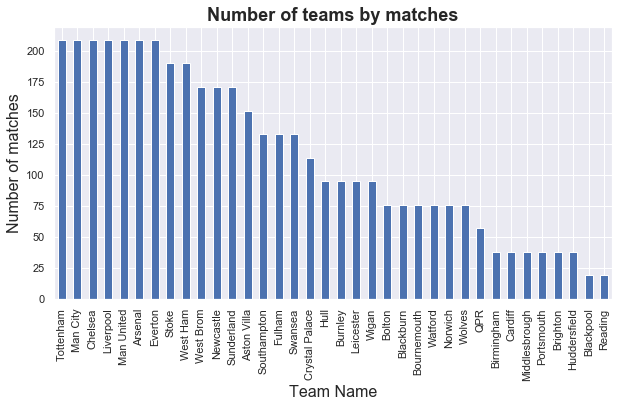

In [588]:
# checking for unbalanced data by teams
df.HomeTeam.value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Number of teams by matches')
plt.ylabel('Number of matches')
plt.xlabel('Team Name');
print(type(df), type(df['FTR']))

### apply transformation for the FTR results

In [589]:
def myTransformResult(e):
    if(e == 'H'):
        return 1
    elif(e == 'A'):
        return -1
    elif(e == 'D'):
        return 0
    else:
         pass

#map the FTR and HTR to {-1,0,1} unbias classes
df['FTR'] = df['FTR'].map(lambda x: myTransformResult(x))
df['HTR'] = df['HTR'].map(lambda x: myTransformResult(x))

df.tail()

# for comparison
# df['FTR_num'] = df['FTR'].map(lambda x: myTransformResult(x))
# df['HTR_num'] = df['HTR'].map(lambda x: myTransformResult(x))

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
4175,12/05/2019,Liverpool,Wolves,2,0,1,1,0,1,M Atkinson,13,7,5,2,3,11,4,1,0,2,0,0
4176,12/05/2019,Man United,Cardiff,0,2,-1,0,1,-1,J Moss,26,13,10,4,9,6,11,2,3,3,0,0
4177,12/05/2019,Southampton,Huddersfield,1,1,0,1,0,1,L Probert,10,10,3,3,8,6,4,3,0,1,0,0
4178,12/05/2019,Tottenham,Everton,2,2,0,1,0,1,A Marriner,11,17,3,9,10,13,7,4,0,2,0,0
4179,12/05/2019,Watford,West Ham,1,4,-1,0,2,-1,C Kavanagh,17,16,8,9,10,10,7,2,1,0,1,0


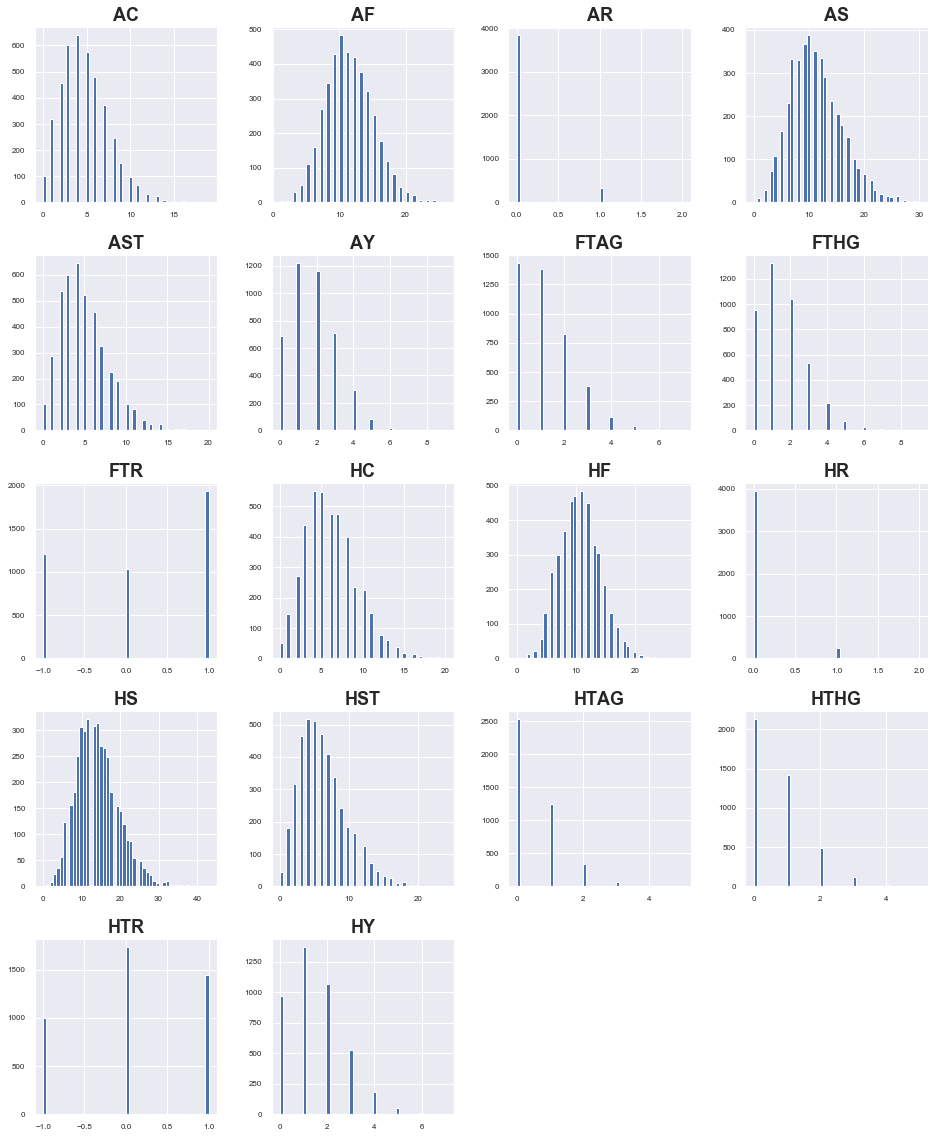

In [590]:
# print(df['HomeTeam'].describe())
#select numerical data
df_num = df.select_dtypes(include = ['int64'])

#plot the histogram of data for a sense of how they distribute
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [596]:
# They 
COR_TO_VAR = 'FTR'
df_num_corr = df_num.corr()[COR_TO_VAR]
df_num_corr = df_num_corr.drop(labels = [COR_TO_VAR])

# print(df_num_corr)
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("Number of strongly correlated values:{}\nThey are\n{}".format(len(golden_features_list), golden_features_list))


# Don't use the plot below, the data features are discrete and can't be shown very well.
# Consider HEATMAP instead
# for i in range(0, len(df_num.columns), 5):
#     sns.pairplot(data=df_num,
#                 x_vars=df_num.columns[i:i+5],
#                 y_vars=['FTR'])

Number of strongly correlated values:3
They are
FTHG    0.621950
HTR     0.610400
FTAG   -0.640924
Name: FTR, dtype: float64


# Feature Engineering

# Methodology Overview

## Feature Extraction

In [19]:
X=training_data[[column for column in training_data.columns if column != 'FTR']]
Y=training_data['FTR']

# Model Training & Validation

## Train the model with all features

In [86]:
def get_scores(model,X,Y):
    scores = cross_validate(model, X, Y, scoring=('accuracy','f1','roc_auc'),
                            cv=10, return_train_score=True,n_jobs=n_cpu)
    print('Accuracy: %f'%(scores['test_accuracy'].mean()))
    print('f1 Score: %f'%(scores['test_f1'].mean()))
    print('ROC - AUC: %f'%(scores['test_roc_auc'].mean()))
    return scores

In [87]:
def get_best_params(model,X,Y,param_grid,refit='accuracy'):
    scoring=('accuracy','f1','roc_auc')
    other_scores=[score for score in list(scoring) if score!=refit] 
    grid_results = RandomizedSearchCV(model, param_grid, 
                                       cv=10,n_jobs=n_cpu,
                                       scoring=scoring,
                                       refit=refit)
    grid_results.fit(X, Y)
    print('Best mean %s Score: '%(refit),grid_results.best_score_)
    print('Best parameters: \n',grid_results.best_params_)
    cv_results=grid_results.cv_results_
    cv_results['mean_test_%s'%(refit)].max()
    best_index_results = np.nonzero(cv_results['rank_test_%s'%(refit)] == 1)[0][0]
    best_index_results['mean_test_%s'%(other_scores[0])][best_index_accuracy]
    best_index_results['mean_test_%s'%(other_scores[1])][best_index_accuracy]
    return model

### Logistic Regression Classifier 

In [96]:
scoring = None

In [95]:
model_LR = LogisticRegression(penalty='l1',n_jobs=n_cpu)
scores_LR = cross_validate(model_LR, X, Y, cv=10, scoring=scoring,return_train_score=True,n_jobs=n_cpu)

ValueError: could not convert string to float: 'C Kavanagh'

### k-NN Classifier

In [98]:
model_knn = KNeighborsClassifier(n_neighbors=5,n_jobs=n_cpu)

scores_knn = cross_validate(model_knn, X, Y, cv=10, scoring=scoring,return_train_score=True,n_jobs=n_cpu)

ValueError: could not convert string to float: '24/08/2009'

### Support Vector Machine Classifier

In [ ]:
model_svm = SVC()

scores_svm = cross_validate(model_svm, X, Y, scoring=scoring,cv=10, return_train_score=True,n_jobs=n_cpu)

### Gaussian Naive Bayes Classifier

In [ ]:
model_gnb=GaussianNB()

scores_gnb=cross_validate(model_gnb,X,Y,scoring=scoring,cv=10,n_jobs=n_cpu)

### SGD Classifier

In [ ]:
model_sgd = SGDClassifier(max_iter=1000000, tol=1e-3)

scores_sgd=cross_validate(model_sgd,X,Y,scoring=scoring,cv=10,n_jobs=n_cpu)

### Multi Layer Perceptron Classifier (Neural Networks)

In [ ]:
model_mlp = MLPClassifier(solver='sgd',activation='identity',learning_rate='adaptive',
                          hidden_layer_sizes=(8, 2), random_state=76)
scores_mlp=cross_validate(model_mlp,X,Y,scoring=scoring,cv=10,n_jobs=n_cpu)

### Random Forest Classifier

In [ ]:
model_rfc = RandomForestClassifier(n_estimators=100,n_jobs=n_cpu)

scores_rfc = cross_validate(model_rfc, X, Y, scoring=scoring,cv=10, return_train_score=True,n_jobs=n_cpu)

## Compare the models

## Train model with selected features

# Results

# Final Predictions on Test Set

# Conclusion